In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

import altair as alt
from altair import *

In [2]:
data_dir = "../../data/labelled-skyspark-data/"

In [12]:
data_without_labels = pd.read_csv(data_dir + "CEC_compiled_data_1a_updated.csv")

In [13]:
data_without_labels.head()

,Datetime,Value,ID,Anomaly
0,2020-01-01 07:58:52,9.6,Campus Energy Centre Campus HW Main Meter Power,False
1,2020-01-01 08:00:00,9.6,Campus Energy Centre Campus HW Main Meter Power,False
2,2020-01-01 08:01:34,10.3,Campus Energy Centre Campus HW Main Meter Power,False
3,2020-01-01 08:04:15,11.0,Campus Energy Centre Campus HW Main Meter Power,False
4,2020-01-01 08:07:36,10.3,Campus Energy Centre Campus HW Main Meter Power,False


In [14]:
data_with_labels = pd.read_csv(data_dir + "CEC_compiled_data_1b_updated.csv")
data_with_labels.head()

,Datetime,Value,ID,Anomaly
0,2020-01-01 07:58:52,9.6,Campus Energy Centre Campus HW Main Meter Power,False
1,2020-01-01 08:00:00,9.6,Campus Energy Centre Campus HW Main Meter Power,False
2,2020-01-01 08:01:34,10.3,Campus Energy Centre Campus HW Main Meter Power,False
3,2020-01-01 08:04:15,11.0,Campus Energy Centre Campus HW Main Meter Power,False
4,2020-01-01 08:07:36,10.3,Campus Energy Centre Campus HW Main Meter Power,False


In [15]:
data_with_labels["Anomaly"].unique()

array([False,  True])

In [16]:
data_without_labels["Anomaly"].unique()

array([False])

In [18]:
data_with_labels.dtypes

Datetime     object
Value       float64
ID           object
Anomaly        bool
dtype: object

In [20]:
data_with_labels.shape

(379846, 4)

In [22]:
data_with_labels.groupby("Anomaly").count()

,Datetime,Value,ID
Anomaly,,,
False,379286,379286,379286
True,560,560,560


In [27]:
print(100*560/379286., "%")

0.14764583981480994 %


In [33]:
# 80 - 20 train test split
train_split_number = int(len(data_with_labels) * .8)
train = data_with_labels.head(train_split_number)
test = data_with_labels.tail(len(data_with_labels) - train_split_number)

# Experiment 1
#### Train on anomalous data and score against human labels
##### Includes data standardization

In [35]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Value']])

train['Value'] = scaler.transform(train[['Value']])
test['Value'] = scaler.transform(test[['Value']])

<ipython-input-35-f6f3514dcb7c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Value'] = scaler.transform(train[['Value']])
<ipython-input-35-f6f3514dcb7c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Value'] = scaler.transform(test[['Value']])


In [37]:
TIME_STEPS=15

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Value']], train['Value'])
X_test, y_test = create_sequences(test[['Value']], test['Value'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (303861, 15, 1)
Testing shape: (75955, 15, 1)


In [39]:
# Architecture found on https://towardsdatascience.com/time-series-of-price-anomaly-detection-with-lstm-11a12ba4f6d9
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 15, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 15, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [40]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')], shuffle=False)


Epoch 1/100
8547/8547 [==============================] - 155s 18ms/step - loss: 0.1011 - val_loss: 0.0901
Epoch 2/100
8547/8547 [==============================] - 153s 18ms/step - loss: 0.0860 - val_loss: 0.0872
Epoch 3/100
8547/8547 [==============================] - 157s 18ms/step - loss: 0.0818 - val_loss: 0.0907
Epoch 4/100
8547/8547 [==============================] - 158s 19ms/step - loss: 0.0790 - val_loss: 0.0915
Epoch 5/100
8547/8547 [==============================] - 138s 16ms/step - loss: 0.0772 - val_loss: 0.0890
Epoch 6/100
8547/8547 [==============================] - 154s 18ms/step - loss: 0.0760 - val_loss: 0.0848
Epoch 7/100
8547/8547 [==============================] - 159s 19ms/step - loss: 0.0757 - val_loss: 0.0861
Epoch 8/100
8547/8547 [==============================] - 164s 19ms/step - loss: 0.0747 - val_loss: 0.0844
Epoch 9/100
8547/8547 [==============================] - 164s 19ms/step - loss: 0.0739 - val_loss: 0.0883
Epoch 10/100
8547/8547 [======================

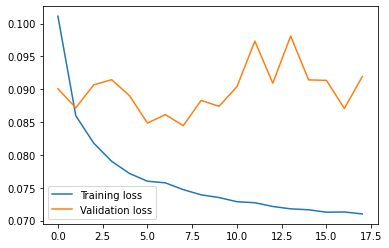

In [41]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [42]:
model.evaluate(X_test, y_test)

2374/2374 [==============================] - 16s 7ms/step - loss: 0.1089


0.10889608412981033

Reconstruction error threshold: 0.8937847562103379


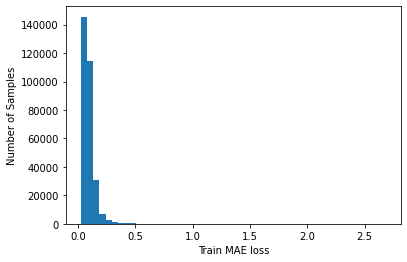

In [86]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# threshold = np.max(train_mae_loss) / 3.0
# threshold = 0.75
print(f'Reconstruction error threshold: {threshold}')

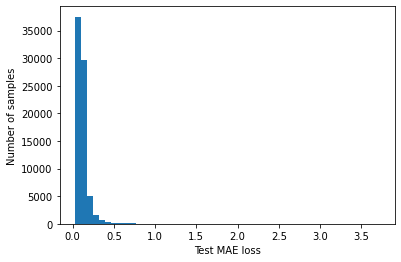

In [87]:

X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

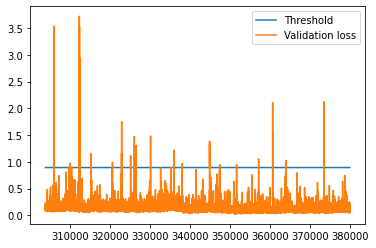

In [88]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly_by_machine'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Value'] = test[TIME_STEPS:]['Value']


plt.plot(test_score_df['threshold'], label='Threshold')
plt.plot(test_score_df['loss'], label='Validation loss')
plt.legend();

In [89]:
anomalies = test_score_df.loc[test_score_df['anomaly_by_machine'] == True]
anomalies.shape

(180, 7)

In [90]:
anomalies.head()

,Datetime,Value,ID,Anomaly,loss,threshold,anomaly_by_machine
306013,2021-02-03 21:30:00,-0.129121,Campus Energy Centre Campus HW Main Meter Power,True,2.116775,0.893785,True
306015,2021-02-03 21:32:04,-0.246443,Campus Energy Centre Campus HW Main Meter Power,True,1.847186,0.893785,True
306016,2021-02-03 21:33:04,2.440222,Campus Energy Centre Campus HW Main Meter Power,True,1.819675,0.893785,True
306017,2021-02-03 21:34:04,1.912275,Campus Energy Centre Campus HW Main Meter Power,True,1.672256,0.893785,True
306018,2021-02-03 21:35:04,1.184881,Campus Energy Centre Campus HW Main Meter Power,True,1.020842,0.893785,True


In [91]:
len(test_score_df)

75955

In [92]:
test_score_df.head()

,Datetime,Value,ID,Anomaly,loss,threshold,anomaly_by_machine
303891,2021-01-31 23:13:20,1.044095,Campus Energy Centre Campus HW Main Meter Power,False,0.097690,0.893785,False
303892,2021-01-31 23:14:50,0.774255,Campus Energy Centre Campus HW Main Meter Power,False,0.111584,0.893785,False
303893,2021-01-31 23:16:41,0.961970,Campus Energy Centre Campus HW Main Meter Power,False,0.124663,0.893785,False
303894,2021-01-31 23:20:00,1.032363,Campus Energy Centre Campus HW Main Meter Power,False,0.092545,0.893785,False
303895,2021-01-31 23:24:56,0.785987,Campus Energy Centre Campus HW Main Meter Power,False,0.119458,0.893785,False


In [93]:
from sklearn.metrics import f1_score

In [94]:
y_true = test_score_df["Anomaly"]

In [95]:
y_pred = test_score_df["anomaly_by_machine"]

In [96]:
f1_score(y_true, y_pred)

0.49298597194388777